In [17]:
!curl -L -H "Accept: application/vnd.github+json" -H "X-GitHub-Api-Version: 2022-11-28" https://api.github.com/repos/OWNER/REPO/pulls/PULL_NUMBER/reviews

{
  "message": "Not Found",
  "documentation_url": "https://docs.github.com/rest/pulls/reviews#list-reviews-for-a-pull-request",
  "status": "404"
}


In [18]:
!(type -p wget >/dev/null || (sudo apt update && sudo apt-get install wget -y)) \
&& sudo mkdir -p -m 755 /etc/apt/keyrings \
&& wget -qO- https://cli.github.com/packages/githubcli-archive-keyring.gpg | sudo tee /etc/apt/keyrings/githubcli-archive-keyring.gpg > /dev/null \
&& sudo chmod go+r /etc/apt/keyrings/githubcli-archive-keyring.gpg \
&& echo "deb [arch=$(dpkg --print-architecture) signed-by=/etc/apt/keyrings/githubcli-archive-keyring.gpg] https://cli.github.com/packages stable main" | sudo tee /etc/apt/sources.list.d/github-cli.list > /dev/null \
&& sudo apt update \
&& sudo apt install gh -y

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Hit:2 https://cli.github.com/packages stable InRelease                         
Hit:3 https://packages.cloud.google.com/apt gcsfuse-focal InRelease            
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 https://packages.cloud.google.com/apt cloud-sdk InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 128 kB in 1s (135 kB/s)33m
Reading package lists... Done
Building dependency tree       
Reading state information... Done
52 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gh is already the newest version (2.59.0).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.


In [19]:
!echo <token> | gh auth login --with-token

In [ ]:
!gh auth token

In [20]:
!gh api -H "Accept: application/vnd.github+json" -H "X-GitHub-Api-Version: 2022-11-28" /repos/TheAlgorithms/Python/pulls/10630/files

[
  {
    "sha": "6ae66b5b0a7780fb79e2b1161f116f62c88579df",
    "filename": "boolean_algebra/and_gate.py",
    "status": "modified",
    "additions": 1,
    "deletions": 1,
    "changes": 2,
    "blob_url": "https://github.com/TheAlgorithms/Python/blob/500d4ebc3936167edebb1d7200bc43363f7af97c/boolean_algebra%2Fand_gate.py",
    "raw_url": "https://github.com/TheAlgorithms/Python/raw/500d4ebc3936167edebb1d7200bc43363f7af97c/boolean_algebra%2Fand_gate.py",
    "contents_url": "https://api.github.com/repos/TheAlgorithms/Python/contents/boolean_algebra%2Fand_gate.py?ref=500d4ebc3936167edebb1d7200bc43363f7af97c",
    "patch": "@@ -29,7 +29,7 @@ def and_gate(input_1: int, input_2: int) -> int:\n     >>> and_gate(1, 1)\n     1\n     \"\"\"\n-    return int((input_1, input_2).count(0) == 0)\n+    return int(input_1 and input_2)\n \n \n if __name__ == \"__main__\":"
  },
  {
    "sha": "ea7a6815dcc982e3c8194b481d88cd685df6cb1e",
    "filename": "boolean_algebra/nand_gate.py",
    "status": "mo

# python SDK

In [2]:
!pip install PyGithub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 5.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 26.4 MB/s eta 0:00:00


In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
token = user_secrets.get_secret("GH_TOKEN2")

In [7]:
from github import Github
import pandas as pd
from tqdm.notebook import tqdm

# Authentication is defined via github.Auth
from github import Auth

# using an access token
auth = Auth.Token(token)

# First create a Github instance:

# Public Web Github
g = Github(auth=auth)

repo = g.get_repo("voxel51/fiftyone")
pulls = repo.get_pulls(state='closed', sort='created')


# Common

In [9]:
def extract_values(data, columns):
    def get_nested_value(data, keys):
        if not keys:
            return data
        key = keys[0]
        if isinstance(data, dict) and key in data:
            return get_nested_value(data[key], keys[1:])
        else:
            return None
    result = {}
    for column in columns:
        keys = column.split('.')
        value = get_nested_value(data, keys)
        result[column] = value
    return result


def extract_pull_request(pr):
    py_files = []
    for f in pr.get_files():
        if f.filename.endswith(".py"):
            file_changes_info = file_changes_serializer(f)
            file_changes_info["pr_id"] = pr.id
            py_files.append(file_changes_info)
    return pd.DataFrame(py_files)

def pr_serializer(pr):
    target_data = pr.__dict__["_rawData"]
    columns = ["id", "title", "number", "state", "title", "body", "review_comments_url", "review_comment_url", "comments_url"]
    filtered = extract_values(target_data, columns)
    return filtered

def extract_pull_request_reviews(pr):
    reviews = []
    columns = ['id', 'body', 'state', 'user.login', 'user.type', 'submitted_at']
    
    for rv in pr.get_reviews():
        filtered = extract_values(rv.__dict__["_rawData"], columns)
        reviews.append(filtered)
    
    return pd.DataFrame(reviews)

def extract_pull_request_review_comments(pr):
    comments = []
    columns = ['pull_request_review_id', 'id', 'diff_hunk', 'path', 'user.login', 'user.type', 'body', 'created_at', 'updated_at', 
               'reactions', 'start_line', 
               'original_start_line', 'start_side', 'line', 'original_line', 'original_position', 'position', 
               'subject_type']
    
    for cms in pr.get_review_comments():
        filtered = extract_values(cms.__dict__["_rawData"], columns)
        comments.append(filtered)
        
    return pd.DataFrame(comments)

def file_changes_serializer(file):
    return file.__dict__["_rawData"]
#     return {
#         "filename": file.filename,
#         "patch": file.patch,
#         "contents_url": f.contents_url,
#         "deletions": f.deletions,
#         "additions": f.additions,
#         "raw_url": f.raw_url,
#         "changes": f.changes,
#         "": f.
#     }

# Pull Requests

In [7]:
pulls.totalCount

3386

In [19]:
# try parallel processing

from multiprocessing import Pool
import pandas as pd
from tqdm import tqdm

with Pool(processes=4) as pool:  
    prs = list(tqdm(pool.imap(pr_serializer, pulls), total=pulls.totalCount))

df_prs = pd.DataFrame(prs)

In [20]:
df_prs

,id,title,number,state,body,review_comments_url,review_comment_url,comments_url
0,407350301,Proposed app related directory structure,1,closed,Proposing that the flask server code resides i...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
1,407363828,Adds Flask main.py,2,closed,,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
2,407479105,App boilerplate,3,closed,This is sets up yarn and adds a prettier pre-c...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
3,407999940,Fixes Electron Boilerplate,4,closed,Adds more tools for the build process.\r\n\r\n...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
4,408009363,Adding example of loading CIFAR10 datasets and...,5,closed,I've heard multiple people are wrangling CIFAR...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
...,...,...,...,...,...,...,...,...
3381,2130199348,Documenting `ctx.user`,4939,closed,\n\n<!-- This is an auto-generated comment: re...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
3382,2130409118,Docs integration updates,4940,closed,## What changes are proposed in this pull requ...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
3383,2131050944,Adds a customizable TextView component,4942,closed,## What changes are proposed in this pull requ...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...
3384,2131363750,rm extra await,4945,closed,## What changes are proposed in this pull requ...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...


In [21]:
df_prs.to_csv("/kaggle/working/fiftyone_pull_rqs.csv", index=False)

# File changes

In [9]:
data = pd.DataFrame([])

for pr in tqdm(pulls[:5]):
    data = pd.concat([data, extract_pull_request(pr)])

0it [00:00, ?it/s]

In [27]:
data

,sha,filename,status,additions,deletions,changes,blob_url,raw_url,contents_url,patch,pr_id
0,00ba655bef883bed6af33905260332ef0a130e8a,fiftyone/server/main.py,added,21,0,21,https://github.com/voxel51/fiftyone/blob/3032d...,https://github.com/voxel51/fiftyone/raw/3032de...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,21 @@\n+""""""\n+FiftyOne Flask server...",407363828
0,d052bd1ef6a04018dc5c6a1f9d6776069bb97f7c,examples/datasets/datasets.py,added,96,0,96,https://github.com/voxel51/fiftyone/blob/1442b...,https://github.com/voxel51/fiftyone/raw/1442b2...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,96 @@\n+""""""\n+Examples of loading c...",408009363
1,b657c098cc0cd6c86ea6cf51e5326a8f0db8a7a7,examples/inference/inference.py,added,72,0,72,https://github.com/voxel51/fiftyone/blob/1442b...,https://github.com/voxel51/fiftyone/raw/1442b2...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,72 @@\n+""""""\n+Examples of performin...",408009363


In [ ]:
# try parallel processing

from multiprocessing import Pool
import pandas as pd
from tqdm import tqdm

if __name__ == "__main__":
    with Pool(processes=4) as pool:
        results = list(tqdm(pool.imap(extract_pull_request, pulls), total=pulls.totalCount))

    data = pd.concat(results, ignore_index=True)

In [ ]:
data.to_csv("/kaggle/working/fiftyone_pulls_changes.csv", index=False)

In [30]:
data = pd.read_csv("/kaggle/input/pullsll/fiftyone_pulls_changes.csv")
data

,sha,filename,status,additions,deletions,changes,blob_url,raw_url,contents_url,patch,pr_id,previous_filename
0,00ba655bef883bed6af33905260332ef0a130e8a,fiftyone/server/main.py,added,21,0,21,https://github.com/voxel51/fiftyone/blob/3032d...,https://github.com/voxel51/fiftyone/raw/3032de...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,21 @@\n+""""""\n+FiftyOne Flask server...",407363828,NaN
1,d052bd1ef6a04018dc5c6a1f9d6776069bb97f7c,examples/datasets/datasets.py,added,96,0,96,https://github.com/voxel51/fiftyone/blob/1442b...,https://github.com/voxel51/fiftyone/raw/1442b2...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,96 @@\n+""""""\n+Examples of loading c...",408009363,NaN
2,b657c098cc0cd6c86ea6cf51e5326a8f0db8a7a7,examples/inference/inference.py,added,72,0,72,https://github.com/voxel51/fiftyone/blob/1442b...,https://github.com/voxel51/fiftyone/raw/1442b2...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,72 @@\n+""""""\n+Examples of performin...",408009363,NaN
3,b1aee5e2a6ac49af3454bdc2363eb83560dfd9d6,examples/datamodel/download_data.py,added,217,0,217,https://github.com/voxel51/fiftyone/blob/ed3df...,https://github.com/voxel51/fiftyone/raw/ed3df6...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,217 @@\n+'''\n+Download CIFAR100 da...",408038954,NaN
4,f768408d19b7d3784b94d61ebf492e9218eabeea,examples/datamodel/nosql/drop_dataset.py,added,19,0,19,https://github.com/voxel51/fiftyone/blob/ed3df...,https://github.com/voxel51/fiftyone/raw/ed3df6...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -0,0 +1,19 @@\n+""""""\n+Drop CIFAR100 dataset...",408038954,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13309,d4ef748473bd2f940894308e8775e4fa282f2213,fiftyone/operators/delegated.py,modified,6,2,8,https://github.com/voxel51/fiftyone/blob/34177...,https://github.com/voxel51/fiftyone/raw/341775...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -404,6 +404,7 @@ def execute_queued_operati...",2129046630,NaN
13310,ef48c78ee9667893bec9db705472b450c652b7c6,tests/unittests/operators/delegated_tests.py,renamed,83,11,94,https://github.com/voxel51/fiftyone/blob/34177...,https://github.com/voxel51/fiftyone/raw/341775...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -55,6 +55,8 @@ def to_json(self):\n \n \n c...",2129046630,tests/unittests/delegated_operators_tests.py
13311,3af9f377a95a09f37cd2af0e3fee43b3c7af8906,fiftyone/operators/executor.py,modified,9,2,11,https://github.com/voxel51/fiftyone/blob/8090f...,https://github.com/voxel51/fiftyone/raw/8090f9...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -385,7 +385,7 @@ async def resolve_type(reg...",2130199348,NaN
13312,6c0f4cd253ec12c71bf391e6205fadd762383617,fiftyone/utils/open_clip.py,modified,2,1,3,https://github.com/voxel51/fiftyone/blob/c5500...,https://github.com/voxel51/fiftyone/raw/c5500b...,https://api.github.com/repos/voxel51/fiftyone/...,"@@ -95,6 +95,7 @@ def _load_model(self, config...",2130409118,NaN


# Comments & Review Comments

In [57]:
df_prs[df_prs["number"] == 4816]

,id,title,number,state,body,review_comments_url,review_comment_url,comments_url
3280,2079154179,ImaVid with new timeline API,4816,closed,## What changes are proposed in this pull requ...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...,https://api.github.com/repos/voxel51/fiftyone/...


In [12]:
pr = pulls[3280] 
rv = pr.get_reviews()
r_cms = pr.get_review_comments()

In [67]:
cms[0].__dict__["_rawData"]["body"]

'_:hammer_and_wrench: Refactor suggestion_\n\n_:warning: Potential issue_\n\n**MinusElement component needs a minor fix and could be improved.**\n\nThe component structure is consistent with PlusElement, which is good. However, there\'s an important oversight:\n\n\nThe `ref` is not passed to the div element. Add it like this:\n```diff\n  <div\n+   ref={ref}\n    {...otherProps}\n    className={`${className} ${playbackElementsStyles.clickable}`}\n    title="Zoom out (-)"\n  >\n```\n\n\nAlso, consider the same type safety improvement as suggested for PlusElement:\n\n```typescript\ninterface MinusElementProps extends React.HTMLProps<HTMLDivElement> {\n  // Add any specific props here\n}\n\nexport const MinusElement = React.forwardRef<HTMLDivElement, MinusElementProps>(\n  ({ className, ...otherProps }, ref) => {\n    // ... rest of the component\n  }\n);\n```\n\nThis will ensure consistency between the two components and improve type safety.\n\n<!-- This is an auto-generated comment by Co

In [66]:
rv[2].__dict__["_rawData"]

{'id': 2326365687,
 'node_id': 'PRR_kwDOD19y-86KqYX3',
 'user': {'login': 'benjaminpkane',
  'id': 19821840,
  'node_id': 'MDQ6VXNlcjE5ODIxODQw',
  'avatar_url': 'https://avatars.githubusercontent.com/u/19821840?u=dc5dbb018aca7573dad98e2f78d6d7d8a610c0bc&v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/benjaminpkane',
  'html_url': 'https://github.com/benjaminpkane',
  'followers_url': 'https://api.github.com/users/benjaminpkane/followers',
  'following_url': 'https://api.github.com/users/benjaminpkane/following{/other_user}',
  'gists_url': 'https://api.github.com/users/benjaminpkane/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/benjaminpkane/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/benjaminpkane/subscriptions',
  'organizations_url': 'https://api.github.com/users/benjaminpkane/orgs',
  'repos_url': 'https://api.github.com/users/benjaminpkane/repos',
  'events_url': 'https://api.github.com/users/benjaminpkane/eve

In [5]:
r_cms[0].__dict__["_rawData"]

{'url': 'https://api.github.com/repos/voxel51/fiftyone/pulls/comments/1773718780',
 'pull_request_review_id': 2325866121,
 'id': 1773718780,
 'node_id': 'PRRC_kwDOD19y-85puMz8',
 'diff_hunk': '@@ -0,0 +1,37 @@\n+import React from "react";\n+import playbackElementsStyles from "./playback-elements.module.css";\n+import MinusIcon from "./svgs/minus.svg?react";\n+import PlusIcon from "./svgs/plus.svg?react";\n+\n+export const PlusElement = React.forwardRef<\n+  HTMLDivElement,\n+  React.HTMLProps<HTMLDivElement>\n+>(({ ...props }, ref) => {\n+  const { className, ...otherProps } = props;\n+  return (\n+    <div\n+      ref={ref}\n+      {...otherProps}\n+      className={`${className} ${playbackElementsStyles.clickable}`}\n+      title="Zoom in (+)"\n+    >\n+      <PlusIcon />\n+    </div>\n+  );\n+});\n+\n+export const MinusElement = React.forwardRef<\n+  HTMLDivElement,\n+  React.HTMLProps<HTMLDivElement>\n+>(({ ...props }, ref) => {\n+  const { className, ...otherProps } = props;\n+  r

In [35]:
extract_pull_request_reviews(pr).head(5)

,id,body,state,user.login,user.type,submitted_at
0,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
1,2325916718,**Actionable comments posted: 1**\n\n<details>...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T17:21:17Z
2,2326365687,,COMMENTED,benjaminpkane,User,2024-09-24T20:47:51Z
3,2326451456,,COMMENTED,coderabbitai[bot],Bot,2024-09-24T20:48:34Z
4,2326686862,This works as expected. I've tested it via the...,APPROVED,ritch,User,2024-09-24T23:22:04Z


In [34]:
extract_pull_request_review_comments(pr).head(5)

,pull_request_review_id,id,diff_hunk,path,user.login,user.type,body,created_at,updated_at,reactions,start_line,original_start_line,start_side,line,original_line,original_position,position,subject_type
0,2325866121,1773718780,"@@ -0,0 +1,37 @@\n+import React from ""react"";\...",app/packages/playback/src/views/LookerElements...,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n_...,2024-09-24T16:56:52Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,NaN,23.0,RIGHT,NaN,37,37,NaN,line
1,2325866121,1773718782,"@@ -0,0 +1,37 @@\n+import React from ""react"";\...",app/packages/playback/src/views/LookerElements...,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,NaN,1.0,RIGHT,NaN,37,37,NaN,line
2,2325866121,1773718787,"@@ -0,0 +1,45 @@\n+/**\n+ * Copyright 2017-202...",app/packages/looker/src/elements/imavid/iv-con...,coderabbitai[bot],Bot,_:warning: Potential issue_\n\n**Unused privat...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,NaN,NaN,None,NaN,13,13,NaN,line
3,2325866121,1773718791,"@@ -0,0 +1,45 @@\n+/**\n+ * Copyright 2017-202...",app/packages/looker/src/elements/imavid/iv-con...,coderabbitai[bot],Bot,_:warning: Potential issue_\n\n**Incomplete im...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,NaN,38.0,RIGHT,NaN,38,44,NaN,line
4,2325866121,1773718793,"@@ -25,6 +25,23 @@\n box-shadow: 0 8px 15px ...",app/packages/looker/src/elements/common/contro...,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,NaN,28.0,RIGHT,NaN,43,19,NaN,line


In [36]:
# left join
merged_df = pd.merge(
    extract_pull_request_review_comments(pr), 
    extract_pull_request_reviews(pr),
    how='left', 
    left_on='pull_request_review_id',
    right_on='id'
)

In [37]:
merged_df

,pull_request_review_id,id_x,diff_hunk,path,user.login_x,user.type_x,body_x,created_at,updated_at,reactions,...,original_line,original_position,position,subject_type,id_y,body_y,state,user.login_y,user.type_y,submitted_at
0,2325866121,1773718780,"@@ -0,0 +1,37 @@\n+import React from ""react"";\...",app/packages/playback/src/views/LookerElements...,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n_...,2024-09-24T16:56:52Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,37,37,NaN,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
1,2325866121,1773718782,"@@ -0,0 +1,37 @@\n+import React from ""react"";\...",app/packages/playback/src/views/LookerElements...,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,37,37,NaN,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
2,2325866121,1773718787,"@@ -0,0 +1,45 @@\n+/**\n+ * Copyright 2017-202...",app/packages/looker/src/elements/imavid/iv-con...,coderabbitai[bot],Bot,_:warning: Potential issue_\n\n**Unused privat...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,13,13,NaN,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
3,2325866121,1773718791,"@@ -0,0 +1,45 @@\n+/**\n+ * Copyright 2017-202...",app/packages/looker/src/elements/imavid/iv-con...,coderabbitai[bot],Bot,_:warning: Potential issue_\n\n**Incomplete im...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,38,44,NaN,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
4,2325866121,1773718793,"@@ -25,6 +25,23 @@\n box-shadow: 0 8px 15px ...",app/packages/looker/src/elements/common/contro...,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,43,19,NaN,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
5,2325866121,1773718806,"@@ -17,61 +18,69 @@ import {\n interface Timel...",app/packages/playback/src/views/Timeline.tsx,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,29,24,24.0,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
6,2325866121,1773718811,"@@ -29,11 +30,21 @@ export const useTimeline =...",app/packages/playback/src/lib/use-timeline.ts,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,37,18,26.0,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
7,2325866121,1773718815,"@@ -29,11 +30,21 @@\n \n const timelineName ...",app/packages/playback/src/lib/use-timeline.ts,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,43,24,32.0,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24T16:56:58Z
8,2325866121,1773718818,"@@ -93,6 +104,16 @@\n [timelineName]\n )...",app/packages/playback/src/lib/use-timeline.ts,coderabbitai[bot],Bot,_:warning: Potential issue_\n\n**Add unit test...,2024-09-24T16:56:53Z,2024-09-24T16:56:58Z,{'url': 'https://api.github.com/repos/voxel51/...,...,116,45,53.0,line,2325866121,**Actionable comments posted: 31**\n\n<details...,COMMENTED,coderabbitai[bot],Bot,2024-09-24

In [10]:
# try parallel processing

from multiprocessing import Pool
import pandas as pd
from tqdm import tqdm
import time

# def get_reviews_and_comments(pr):
#     #left join
#     merged_df = pd.merge(
#         extract_pull_request_review_comments(pr), 
#         extract_pull_request_reviews(pr),
#         how='left', 
#         left_on='pull_request_review_id', 
#         right_on='id'
#     )
#     return merged_df

# with Pool(processes=4) as pool:
#     results = list(tqdm(pool.imap(get_reviews_and_comments, pulls), total=pulls.totalCount))


# with Pool(processes=4) as pool:
#     cmss = list(tqdm(pool.imap(extract_pull_request_review_comments, pulls), total=pulls.totalCount))

# time.sleep(10)

with Pool(processes=4) as pool:
    rvss = list(tqdm(pool.imap(extract_pull_request_reviews, pulls), total=pulls.totalCount))
    
# comments = pd.concat(cmss, ignore_index=True)
reviews = pd.concat(rvss, ignore_index=True)

100%|██████████| 3389/3389 [07:43<00:00,  7.31it/s]


In [12]:
reviews.to_csv("/kaggle/working/pr_reviews.csv", index=False)

In [9]:
comments = pd.concat(cmss, ignore_index=True)
comments.to_csv("/kaggle/working/pr_comments.csv", index=False)

/tmp/ipykernel_30/3569678742.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comments = pd.concat(cmss, ignore_index=True)


In [ ]:
df_comments.to_csv("/kaggle/working/pr_review_comments.csv", index=False)

# Analysis data

In [15]:
df_comments = pd.read_csv("/kaggle/input/inputs-crawled/pr_comments.csv")
df_pull_requests = pd.read_csv("/kaggle/input/inputs-crawled/fiftyone_pull_rqs.csv")
df_reviews = pd.read_csv("/kaggle/input/inputs-crawled/pr_reviews.csv")
df_file_changes = pd.read_csv("/kaggle/input/inputs-crawled/fiftyone_pulls_file_changes.csv")

In [26]:
print(df_pull_requests.head(5).to_dict())
print(df_comments.head(5).to_dict())
print(df_reviews.head(5).to_dict())
print(df_file_changes.head(5).to_dict())

{'id': {0: 407350301, 1: 407363828, 2: 407479105, 3: 407999940, 4: 408009363}, 'title': {0: 'Proposed app related directory structure', 1: 'Adds Flask main.py', 2: 'App boilerplate', 3: 'Fixes Electron Boilerplate', 4: 'Adding example of loading CIFAR10 datasets and performing inference with pretrained models, using Pytorch'}, 'number': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}, 'state': {0: 'closed', 1: 'closed', 2: 'closed', 3: 'closed', 4: 'closed'}, 'body': {0: 'Proposing that the flask server code resides in `fiftyone/server` and the react/electron app code resides in `fiftyone/app`.', 1: nan, 2: 'This is sets up yarn and adds a prettier pre-commit hook.\r\n\r\n@lethosor I think you have more experience with webpack, babel, etc. Would you want to set that up?\r\n\r\nI know there are other options like Next.js, Create React App, etc. Not sure what the best option is.\r\n\r\nI am also thinking of using Semantic UI. See https://react.semantic-ui.com/usage', 3: 'Adds more tools for the build pro

In [16]:
# left join
df_comments = pd.merge(
    df_comments, 
    df_reviews,
    how='left', 
    left_on='pull_request_review_id',
    right_on='id'
)
df_comments

,pull_request_review_id,id_x,diff_hunk,path,user.login_x,user.type_x,body_x,created_at,updated_at,reactions,...,original_line,original_position,position,subject_type,id_y,body_y,state,user.login_y,user.type_y,submitted_at
0,399307082,413974521,"@@ -0,0 +1,84 @@\n+""""""\n+Examples of loading c...",examples/datasets.py,tylerganter,User,This is not in the requirements. I'm taking th...,2020-04-23T17:10:47Z,2020-04-30T07:53:43Z,{'url': 'https://api.github.com/repos/voxel51/...,...,14,14,NaN,line,399307082,NaN,COMMENTED,tylerganter,User,2020-04-23T17:10:47Z
1,399308669,413975894,"@@ -0,0 +1,84 @@\n+""""""\n+Examples of loading c...",examples/datasets.py,tylerganter,User,Also missing `matplotlib`,2020-04-23T17:12:49Z,2020-04-30T07:53:43Z,{'url': 'https://api.github.com/repos/voxel51/...,...,14,14,NaN,line,399308669,NaN,COMMENTED,tylerganter,User,2020-04-23T17:12:49Z
2,399309048,413976226,"@@ -0,0 +1,84 @@\n+""""""\n+Examples of loading c...",examples/datasets.py,brimoor,User,What about a requirements file in `examples/` ...,2020-04-23T17:13:20Z,2020-04-30T07:53:43Z,{'url': 'https://api.github.com/repos/voxel51/...,...,14,14,NaN,line,399309048,NaN,COMMENTED,brimoor,User,2020-04-23T17:13:21Z
3,399312267,413979047,"@@ -0,0 +1,84 @@\n+""""""\n+Examples of loading c...",examples/datasets.py,tylerganter,User,yep that works for me,2020-04-23T17:17:31Z,2020-04-30T07:53:43Z,{'url': 'https://api.github.com/repos/voxel51/...,...,14,14,NaN,line,399312267,NaN,COMMENTED,tylerganter,User,2020-04-23T17:17:31Z
4,401105029,415947245,"@@ -0,0 +1,82 @@\n+""""""\n+Examples of loading c...",examples/datasets.py,tylerganter,User,should be `torchvision.datasets.CocoDetection`...,2020-04-27T16:08:39Z,2020-04-30T07:53:43Z,{'url': 'https://api.github.com/repos/voxel51/...,...,80,80,NaN,line,401105029,NaN,COMMENTED,tylerganter,User,2020-04-27T16:08:39Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5966,2376234257,1805394362,"@@ -646,7 +646,21 @@ def current_sample(self):...",fiftyone/operators/executor.py,ritch,User,`ctx.user_request_token` is OK to be available...,2024-10-17T20:33:25Z,2024-10-17T20:33:25Z,{'url': 'https://api.github.com/repos/voxel51/...,...,660,34,28.0,line,2376234257,NaN,COMMENTED,ritch,User,2024-10-17T20:33:25Z
5967,2376333461,1805455169,"@@ -0,0 +1,59 @@\n+import { Box, Typography } ...",app/packages/core/src/plugins/SchemaIO/compone...,coderabbitai[bot],Bot,_:hammer_and_wrench: Refactor suggestion_\n\n*...,2024-10-17T21:28:53Z,2024-10-17T21:28:54Z,{'url': 'https://api.github.com/repos/voxel51/...,...,26,26,26.0,line,2376333461,**Actionable comments posted: 1**\n\n<details>...,COMMENTED,coderabbitai[bot],Bot,2024-10-17T21:28:54Z
5968,2378626632,1806807483,"@@ -0,0 +1,59 @@\n+import { Box, Typography } ...",app/packages/core/src/plugins/SchemaIO/compone...,imanjra,User,@manivoxel51 Sorry for the late review. We sho...,2024-10-18T17:21:05Z,2024-10-18T17:21:05Z,{'url': 'https://api.github.com/repos/voxel51/...,...,19,19,19.0,line,2378626632,NaN,COMMENTED,imanjra,User,2024-10-18T17:21:05Z
5969,2378742679,1806879374,"@@ -0,0 +1,59 @@\n+import { Box, Typography } ...",app/packages/core/src/plugins/SchemaIO/compone...,manivoxel51,User,you are right! will patch it shortly 🙇,2024-10-18T18:34:24Z,2024-10-18T18:34:24Z,{'url': 'https://api.github.com/repos/voxel51/...,...,19,19,19.0,line,2378742679,NaN,COMMENTED,manivoxel51,User,2024-10-18T18:34:24Z


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

def plot_pull_request_states(df_pull_requests):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df_pull_requests, x='state')
    plt.title('Distribution of Pull Request States')
    plt.xlabel('State')
    plt.ylabel('Count')
    plt.show()

def plot_review_states(df_reviews):
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df_reviews, x='state')
    plt.title('Distribution of Review States')
    plt.xlabel('Review State')
    plt.ylabel('Count')
    plt.show()

def plot_bot_review(df_comments):
    plt.figure(figsize=(20, 20))
    sns.countplot(data=df_comments, x='user.login_x')
    plt.title('Distribution of Comment by bot')
    plt.xlabel('User')
    plt.ylabel('Count')
    plt.show()

def plot_file_changes_per_pr(df_file_changes, df_pull_requests):
    changes_per_pr = df_file_changes.groupby('pr_id').sum()
    merged_df = df_pull_requests.merge(changes_per_pr, left_on='id', right_on='pr_id', how='left')

    plt.figure(figsize=(12, 6))
    sns.barplot(x='number', y='additions', data=merged_df, color='blue', label='Additions')
    sns.barplot(x='number', y='deletions', data=merged_df, color='red', label='Deletions')
    plt.title('File Changes per Pull Request')
    plt.xlabel('Pull Request Number')
    plt.ylabel('Changes')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

def plot_correlation_comments_file_changes(df_comments, df_file_changes):
    comments_count = df_comments.groupby('pull_request_review_id').size()
    file_changes = df_file_changes.groupby('pr_id').sum()

    merged_df = file_changes.merge(comments_count, left_on='pr_id', right_on='pull_request_review_id', how='left')
    merged_df['comments'] = merged_df[0].fillna(0)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='comments', y='changes', data=merged_df)
    plt.title('Correlation between Number of Comments and File Changes')
    plt.xlabel('Number of Comments')
    plt.ylabel('Number of Changes')
    plt.show()



def plot_reactions_per_comment(df_comments):
    df_comments['reactions_parsed'] = df_comments['reactions'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
    df_comments['total_reactions'] = df_comments['reactions_parsed'].apply(lambda x: x.get('total_count', 0))

    plt.figure(figsize=(8, 6))
    sns.histplot(df_comments['total_reactions'], bins=10, kde=True)
    plt.title('Distribution of Reactions per Comment')
    plt.xlabel('Number of Reactions')
    plt.ylabel('Count')
    plt.show()


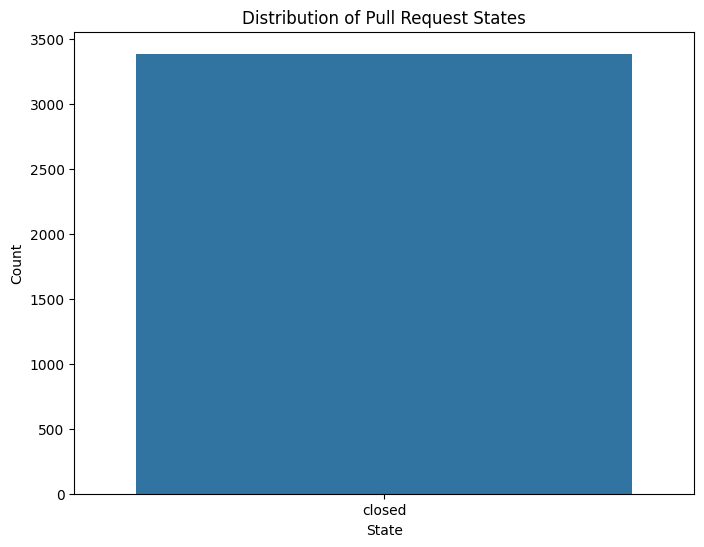

In [28]:
plot_pull_request_states(df_pull_requests)

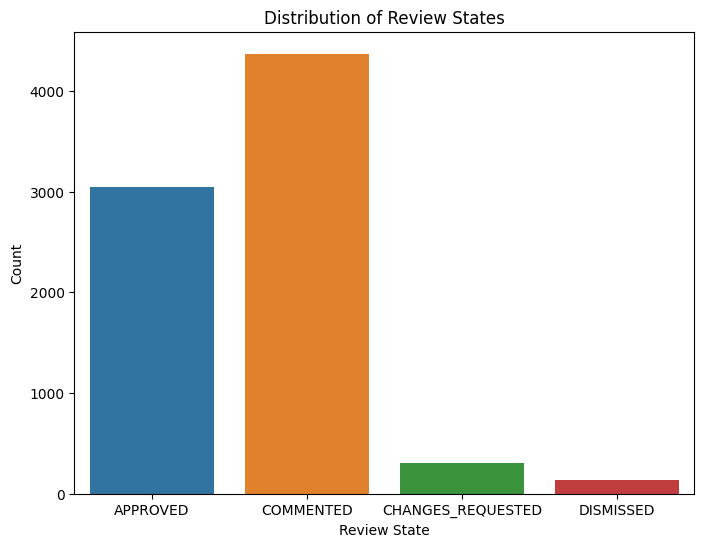

In [29]:
plot_review_states(df_reviews)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


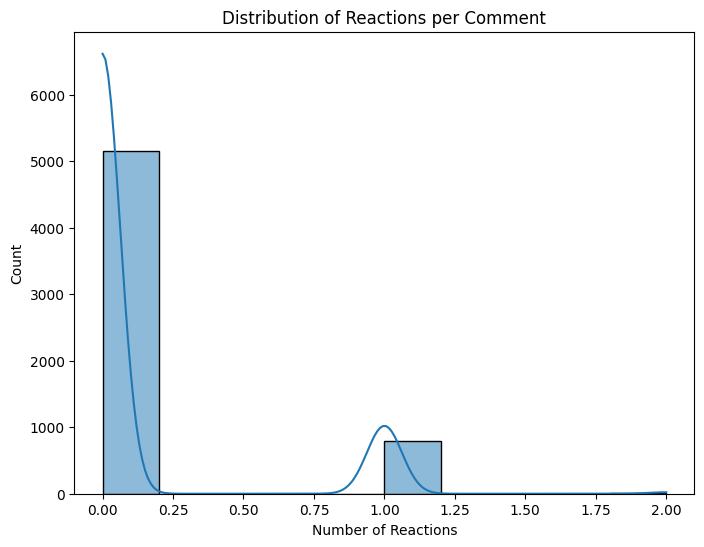

In [31]:
plot_reactions_per_comment(df_comments)

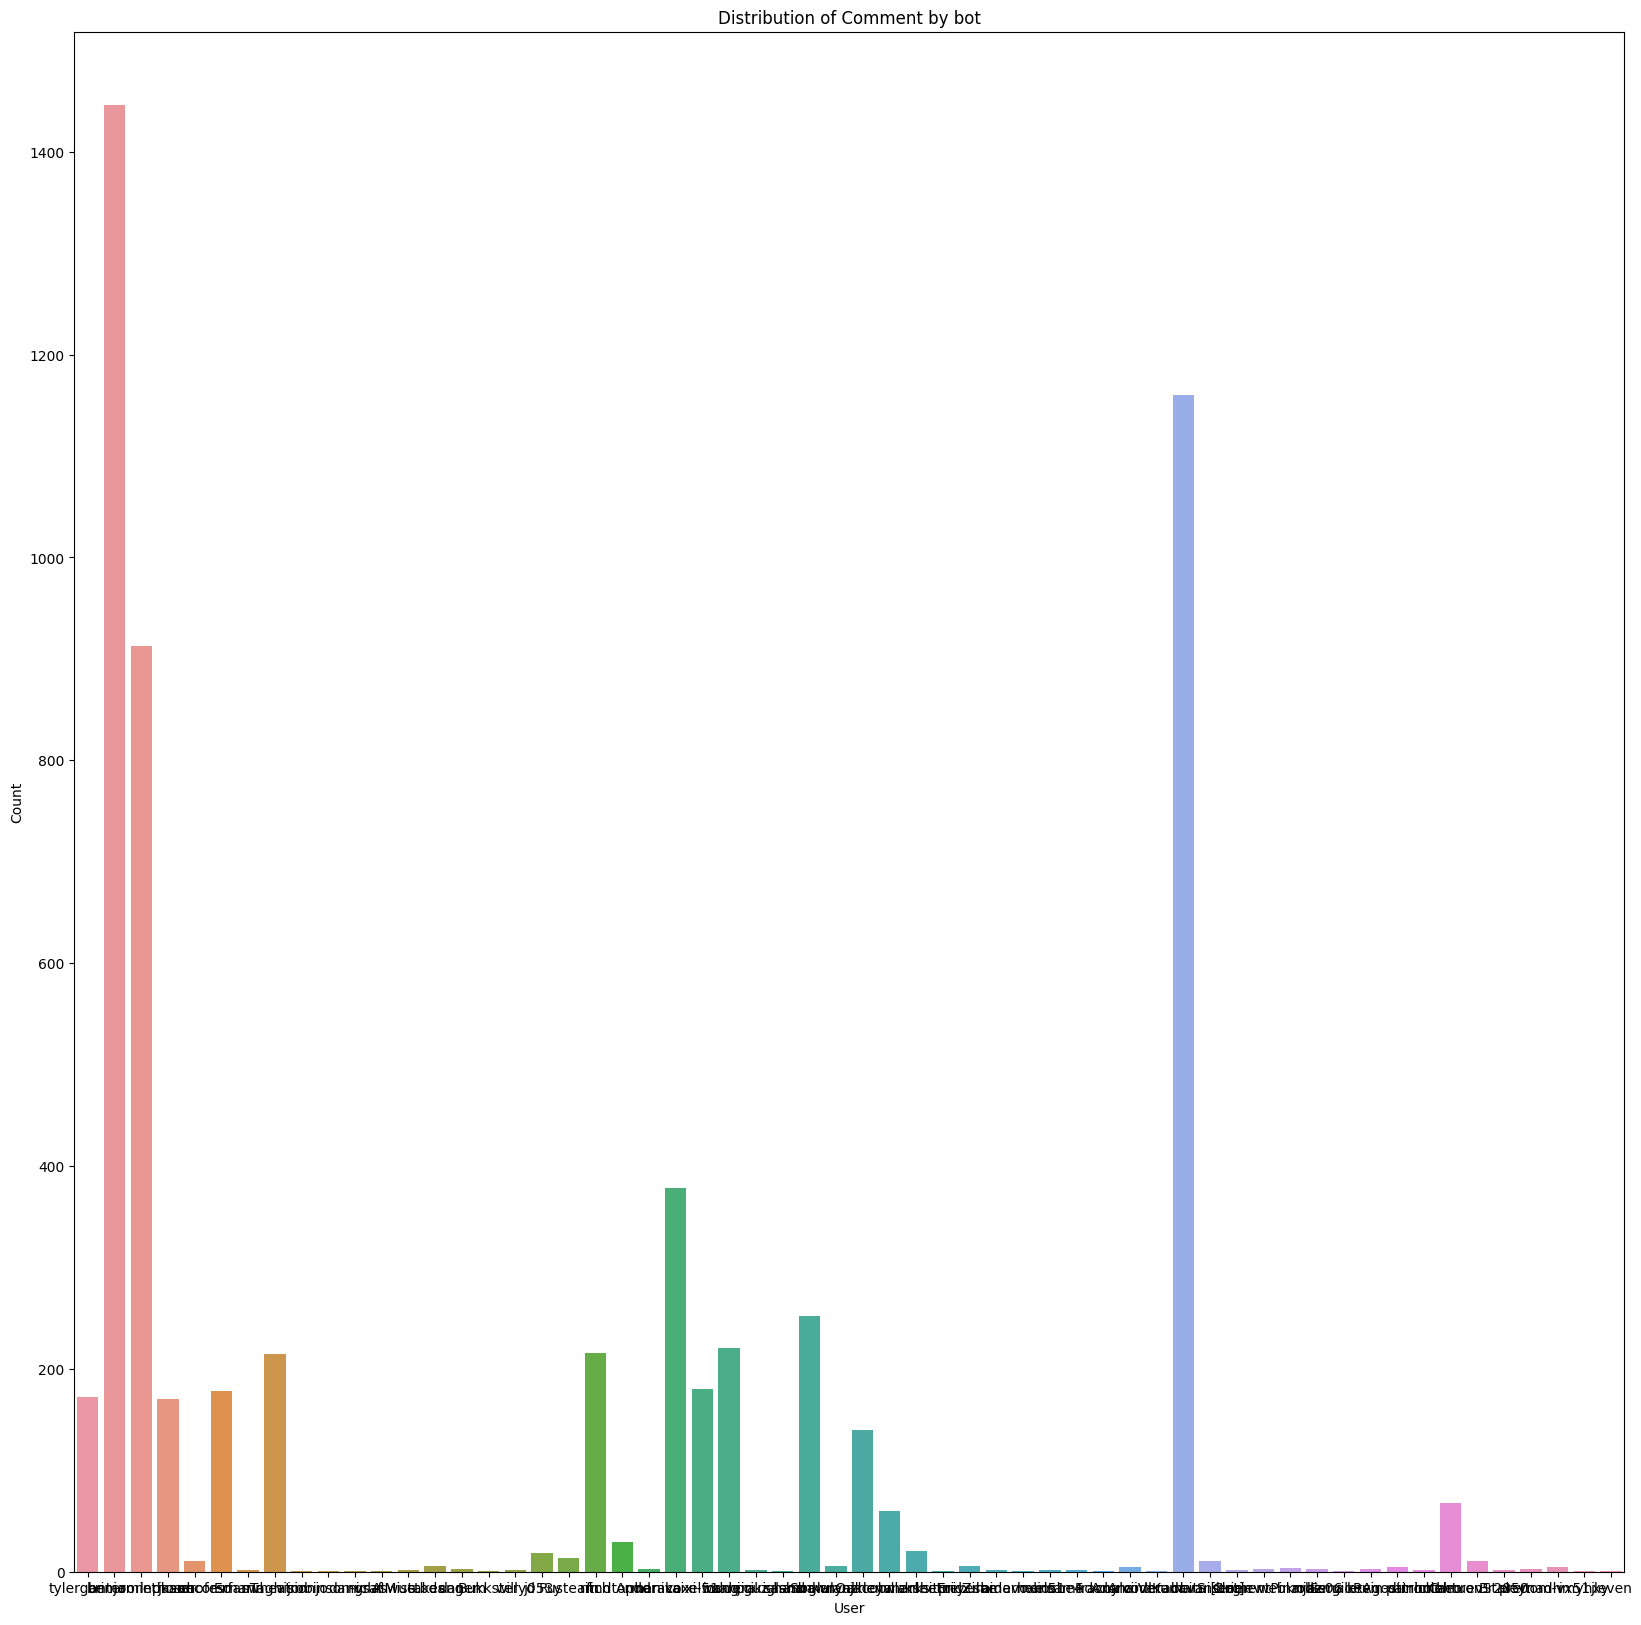

In [35]:
plot_bot_review(df_comments)